# English to French translation system with transformers I: Data cleaning 

In this notebook, we shall prepare a dataset that shall be used to train a transformer-based English to French translation system. 

The raw dataset, which contains a large list of English-French sentence pairs, shall be processed and simplified:
- Capitalisation and excess punctuation shall be removed. Data-points with certain special characters shall be removed.
- The dataset contains many duplicates (i.e. English sentences with multiple distinct French translations). These may cause difficulty training the model. We shall remove all but one datapoint for each set of duplicates. 
- The transformer model takes in sentences of a fixed maximum length, hence we set this value and remove sentences longer that this length. Setting the maximum length too big will lead to a larger model (requires more compute to train), whereas setting it too small will lead to too many data-points being removed.  
- The output of the transformer model is a discrete probability distributions over a set of French word (the set of "known French words"). We shall construct this set based on frequency of appearance in the dataset and replace French words not in the list by an "unknown token" `<unk>`. If this set is too large, then the model shall be too large to train with our resources. If it too small then we will lose too much information due to unknown words. 


In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re # regex
from tqdm import tqdm
from collections import Counter
import torchtext

## Dataset

We shall use the tab-separated En - Fr sentence pairs dataset found on this site:
http://www.manythings.org/bilingual/. 

Loading the dataset into a pandas dataframe:

In [2]:
data = pd.read_csv("/kaggle/input/frenchenglish/fra.txt", sep="\t", header=None)
data = data.drop(2, axis = 1) # Drop final column 
data = data.set_axis(['En','Fr'], axis = 1) # Rename columns
data

,En,Fr
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !
...,...,...
177205,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."
177206,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
177207,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
177208,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...


## Data-cleaning:

### Sentence cleaning

Based on previous data exploration, we shall make the following simplications to the dataset (the order is important):
- Make all text lower case.
- Remove datapoints with sequence '! ', i.e. exclamation mark in the middle of a sentence.
- Remove full stops and exclamation marks.
- Treat commas and question marks like single word tokens. That is, replace "?" by " ? " and "," by " , ". 
- Remove datapoints with sequences '-  ', ' -', " '" or "' ". 
- Replace unbreakable spaces '\xa0', '\xad', '\u2009', '\u200b', '\u202f' by spaces.
- Remove any data points containing non-alphabetical characters not in { -',?}.
- Replace double/triple spaces by spaces.
- Remove any spaces at the start and end of sentences.
- Remove any remaining double quotation marks.
- Split words concatenated with dashes or apostrophes and treat the latter as single word tokens (replace "'" by " ' " and "-" by " - "). The reason for this is that the word embedding models we shall use down the line don't recognise words like "we're" and "c'est".


In [3]:
data_clean = data.copy()

In [4]:
# Make data lowercase
def lower(row):
    row.En = row.En.lower()
    row.Fr = row.Fr.lower()
    return row
data_clean = data_clean.apply(lower, axis='columns')


In [5]:
# Remove datapoints with sequence '! ', i.e. exclamation mark in the middle of a sentence.
def exclam_middle(row):
    tst_en = bool(re.search('! ', row.En))
    tst_fr = bool(re.search('! ', row.Fr))
    return tst_en or tst_fr
exclam_middle_indices = data_clean.apply(exclam_middle, axis='columns')
data_clean = data_clean.loc[exclam_middle_indices == False]

In [6]:
# test
search = lambda string: bool(re.search('! ', string)) 
en_num = data_clean["En"].apply(search)
fr_num = data_clean["Fr"].apply(search)
idx_ser = en_num + fr_num > 0 
data_search = data_clean.loc[idx_ser, ["En", "Fr"]]
len(data_search) == 0

True

In [7]:
# Remove full stops and exclamation marks.
def remove_full_exclam(row):
    row.En = row.En.replace('.','').replace('!','')
    row.Fr = row.Fr.replace('.','').replace('!','')
    return row
data_clean = data_clean.apply(remove_full_exclam, axis='columns')

In [8]:
# test
search = lambda string: bool(re.search('[.!]', string))
en_num = data_clean["En"].apply(search)
fr_num = data_clean["Fr"].apply(search)
idx_ser = en_num + fr_num > 0 
data_search = data_clean.loc[idx_ser, ["En", "Fr"]]
len(data_search) == 0

True

In [9]:
# Replace "?" by " ? " and "," by " , "
def replace_quest_comma(row):
    row.En = row.En.replace('?',' ? ').replace(',',' , ')
    row.Fr = row.Fr.replace('?',' ? ').replace(',',' , ')
    return row
data_clean = data_clean.apply(replace_quest_comma, axis='columns')

In [10]:
# test comma
search = lambda string: bool(re.search(',', string.replace(' ,','') ))
en_num = data_clean["En"].apply(search)
fr_num = data_clean["Fr"].apply(search)
idx_ser = en_num + fr_num > 0 
data_search = data_clean.loc[idx_ser, ["En", "Fr"]]
len(data_search) == 0

True

In [11]:
# test q mark
search = lambda string: bool(re.search('\?', string.replace(' ?','' )))
en_num = data_clean["En"].apply(search)
fr_num = data_clean["Fr"].apply(search)
idx_ser = en_num + fr_num > 0 
data_search = data_clean.loc[idx_ser, ["En", "Fr"]]
len(data_search) == 0

True

In [12]:
# Remove datapoints with sequences '-  ', ' -', " '" or "' ". 
def dash_apost(row):
    tst_en = bool(re.search("- | -| '|' ", row.En)) 
    tst_fr = bool(re.search("- | -| '|' ", row.Fr))
    return tst_en or tst_fr
dash_apost_indices = data_clean.apply(dash_apost, axis='columns')
data_clean = data_clean.loc[dash_apost_indices == False]

In [13]:
# test
search = lambda string: bool(re.search("- | -| '|' ", string))
en_num = data_clean["En"].apply(search)
fr_num = data_clean["Fr"].apply(search)
idx_ser = en_num + fr_num > 0 
data_search = data_clean.loc[idx_ser, ["En", "Fr"]]
len(data_search) == 0

True

In [14]:
# test apost
search = lambda string: bool(re.search("'", string.replace(" '","") ))
en_num = data_clean["En"].apply(search)
fr_num = data_clean["Fr"].apply(search)
idx_ser = en_num + fr_num > 0 
data_search = data_clean.loc[idx_ser, ["En", "Fr"]]
len(data_search) == 0

False

In [15]:
# Replace unbreakable spaces by spaces.
def replace_unbreak(row):
    row.En = re.sub('\xa0|\xad|\u2009|\u200b|\u202f',' ', row.En)
    row.Fr = re.sub('\xa0|\xad|\u2009|\u200b|\u202f',' ', row.Fr)
    return row
data_clean = data_clean.apply(replace_unbreak, axis='columns')

In [16]:
# test
search = lambda string: bool(re.search("\xa0|\xad|\u2009|\u200b|\u202f", string))
en_num = data_clean["En"].apply(search)
fr_num = data_clean["Fr"].apply(search)
idx_ser = en_num + fr_num > 0 
data_search = data_clean.loc[idx_ser, ["En", "Fr"]]
len(data_search) == 0

True

In [17]:
# Set of alphabetical characters 
alpha_set = {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Â', 'Ç', 'É', 'Ê', 'Ô', 'à', 'á', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'ü', 'ō', 'œ'}
alpha_set_lower = set([letter.lower() for letter in alpha_set])
# Set of allowed characters 
allowed_chars = alpha_set_lower.union([' ','-',"'",',','?'])
# Remove any data points containing non-alphabetical characters not in { -',?}.
def remove_rest(row):
    # Sentence contains non-allowed chars?
    non_alph_bool_en = len(allowed_chars.union(set(row.En))) > len(allowed_chars)
    non_alph_bool_fr = len(allowed_chars.union(set(row.Fr))) > len(allowed_chars)
    return non_alph_bool_en or non_alph_bool_fr
remove_rest_indices = data_clean.apply(dash_apost, axis='columns')
data_clean = data_clean.loc[remove_rest_indices == False]

In [18]:
# Set of alphabetical characters 
alpha_set_lower = set([letter.lower() for letter in alpha_set])
# Set of allowed characters 
allowed_chars = alpha_set_lower.union([' ','-',"'",',','?'])

In [19]:
# Remove any data points containing non-alphabetical characters not in { -',?}.
def remove_rest(row):
    # Sentence contains non-allowed chars?
    non_alph_bool_en = len(allowed_chars.union(set(row.En))) > len(allowed_chars)
    non_alph_bool_fr = len(allowed_chars.union(set(row.Fr))) > len(allowed_chars)
    return non_alph_bool_en or non_alph_bool_fr
remove_rest_indices = data_clean.apply(remove_rest, axis='columns')
data_clean = data_clean.loc[remove_rest_indices == False]

In [20]:
# test
char_set = set()
for idx in range(len(data_clean["En"])): 
    char_set = char_set.union(set(data_clean.iloc[idx].En))
    char_set = char_set.union(set(data_clean.iloc[idx].Fr))
char_set.issubset(allowed_chars)

True

In [21]:
# Removing double and triple spaces
def replace_mult_space(row):
    row.En = re.sub('   ',' ', row.En) # triple space
    row.En = re.sub('  ',' ', row.En) # double space 
    row.Fr = re.sub('   ',' ', row.Fr) # triple space
    row.Fr = re.sub('  ',' ', row.Fr) # double space 
    return row
data_clean = data_clean.apply(replace_mult_space, axis='columns')

In [22]:
# test
search = lambda string: bool(re.search("  |   |    ", string)) # testing for up to quadruple spaces
en_num = data_clean["En"].apply(search)
fr_num = data_clean["Fr"].apply(search)
idx_ser = en_num + fr_num > 0 
data_search = data_clean.loc[idx_ser, ["En", "Fr"]]
len(data_search) == 0

True

In [23]:
# Removing leading and trailing spaces
def replace_lead_trail(row):
    row.En = re.sub('^ ','', row.En) # remove leading space
    row.En = re.sub(' $','', row.En) # remove trailing space
    row.Fr = re.sub('^ ','', row.Fr) # remove leading space
    row.Fr = re.sub(' $','', row.Fr) # remove trailing space
    return row
data_clean = data_clean.apply(replace_lead_trail, axis='columns')

In [24]:
# test
search = lambda string: bool(re.search("^ | $", string)) # ^ means starts with, $ means ends with 
en_num = data_clean["En"].apply(search)
fr_num = data_clean["Fr"].apply(search)
idx_ser = en_num + fr_num > 0 
data_search = data_clean.loc[idx_ser, ["En", "Fr"]]
len(data_search) == 0

True

In [25]:
# Remove any remaining quotation marks.
def remove_quot(row):
    row.En = re.sub('"','', row.En)
    row.En = re.sub("''",'', row.En)
    row.Fr = re.sub('"','', row.Fr)
    row.Fr = re.sub("''",'', row.Fr)
    return row
data_clean = data_clean.apply(remove_quot, axis='columns')

In [26]:
# test
search1 = lambda string: bool(re.search('"', string))
search2 = lambda string: bool(re.search("'", string))
en_num1 = data_clean["En"].apply(search1)
fr_num1 = data_clean["Fr"].apply(search1)
en_num2 = data_clean["En"].apply(search2)
fr_num2 = data_clean["Fr"].apply(search2)
idx_ser = en_num1 + fr_num1 + en_num2 + fr_num2 > 0 
data_search = data_clean.loc[idx_ser, ["En", "Fr"]]
len(data_search) == 0

False

In [27]:
# Replace "-" by " - " and "'" by " ' "
def replace_dash_apost(row):
    row.En = row.En.replace('-',' - ').replace("'"," ' ")
    row.Fr = row.Fr.replace('-',' - ').replace("'"," ' ")
    return row
data_clean = data_clean.apply(replace_dash_apost, axis='columns')

In [28]:
# test dash
search = lambda string: bool(re.search('-', string.replace(' -','') ))
en_num = data_clean["En"].apply(search)
fr_num = data_clean["Fr"].apply(search)
idx_ser = en_num + fr_num > 0 
data_search = data_clean.loc[idx_ser, ["En", "Fr"]]
len(data_search) == 0

True

### Duplicates and long sentences

#### Exploring sentence length 

There are some quite long sentences in the dataset, e.g.:

In [29]:
data_clean.iloc[-1].En

"if someone who doesn ' t know your background says that you sound like a native speaker , it means they probably noticed something about your speaking that made them realize you weren ' t a native speaker in other words , you don ' t really sound like a native speaker"

Length of above sentence:

In [30]:
print(f"{len(data_clean.iloc[-1].En.split(' '))} words")

52 words


Computing lengths of the sentences in the dataset:

In [31]:
def len_sents(row):
    row.En = len(row.En.split(' '))
    row.Fr = len(row.Fr.split(' '))
    return row
lengths_df = data_clean.copy()
lengths_df = lengths_df.apply(len_sents, axis = 'columns')

In [32]:
lengths_df

,En,Fr
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
177203,35,43
177206,34,35
177207,42,53
177208,46,58


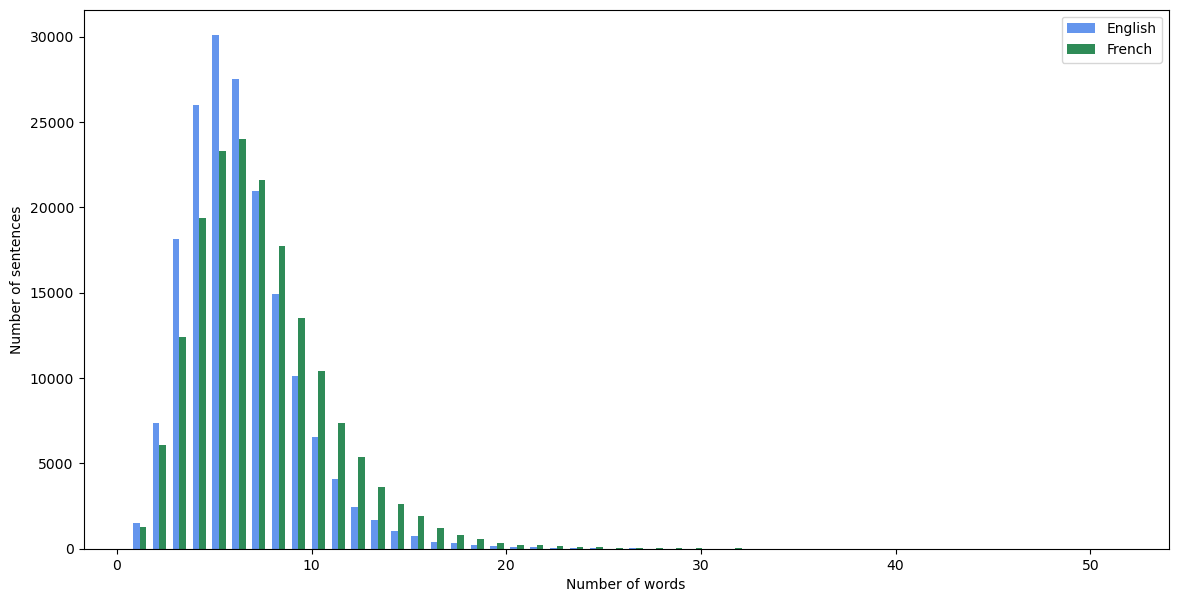

In [33]:
fig, ax = plt.subplots(figsize = (14,7))

a_heights, a_bins = np.histogram(lengths_df.En, bins = 50)
b_heights, b_bins = np.histogram(lengths_df.Fr, bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue', label = 'English')
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen', label = 'French')
ax.set_ylabel('Number of sentences')
ax.set_xlabel('Number of words')
ax.legend()
plt.show()

6 - 8 seems like a good number of maximum words to take.

### Removing duplicates and clipping sentence size

#### Duplicates

There are many duplicates in the dataset, in the sense of sets of datapoints with the same English sentence translated in multiple different ways. 

In such cases, we shall keep only the first translation.

In [34]:
data_nodup = data_clean.drop_duplicates(subset = ['En'], keep = 'first')

In [35]:
data_nodup

,En,Fr
0,go,va
1,hi,salut
3,run,cours
5,who ?,qui ?
6,wow,ça alors
...,...,...
177203,there are four main causes of alcohol - relate...,il y a quatre causes principales de décès liés...
177206,a carbon footprint is the amount of carbon dio...,une empreinte carbone est la somme de pollutio...
177207,death is something that we ' re often discoura...,la mort est une chose qu ' on nous décourage s...
177208,since there are usually multiple websites on a...,puisqu ' il y a de multiples sites web sur cha...


#### Max sentence length

In [36]:
# Maximum sentence length 
N = 7

In [37]:
# Max length of sentence pair
max_len = lambda row: max([len(row.En.split(' ')), len(row.Fr.split(' '))])
maxlen = data_nodup.copy()
maxlen = maxlen.apply(max_len, axis = 'columns')

In [38]:
data_fin = data_nodup.loc[maxlen <= N, :]

In [39]:
data_fin.head(40)

,En,Fr
0,go,va
1,hi,salut
3,run,cours
5,who ?,qui ?
6,wow,ça alors
7,fire,au feu
8,help,à l ' aide
9,jump,saute
10,stop,ça suffit
13,wait,attends


In [40]:
# Saving the final cleaned dataset
data_fin.to_csv("/kaggle/working/EnFr_cleaned.txt")

## French word-list

The output of the transformer shall be a discrete probability distribution over a list of French words encountered in the dataset.

We shall limit the length of this word-list to make training faster. French words that aren't in the word-list but are still in the dataset shall be replace by the "unkown token" `<unk>`.  

We need to find a length for the word-list which finds a good balance between not being to big, but still most sentences in the dataset not having the unknown token. 

#### Exploring word-list size

First, we shall construct a dictionary of French words, along with the number of times it appears inside the French column of the dataset.

In [41]:
counter = Counter()
for i in tqdm(range(len(data_fin))):
    counter = counter + Counter(data_fin.Fr.iloc[i].split())

100%|██████████| 53869/53869 [02:55<00:00, 307.55it/s]


In [42]:
# Convert counter to Pandas dataframe
counter_df = pd.DataFrame({'word':pd.Series(dict(counter).keys()), 'frequency':pd.Series(dict(counter).values())})
# Sort counter
counter_df = counter_df.sort_values(by = 'frequency', axis = 0, ascending=False)
counter_df.reset_index().drop('index', axis = 1)

,word,frequency
0,',13356
1,je,9893
2,est,8880
3,tom,5771
4,de,5322
...,...,...
13760,remédier,1
13761,écrasante,1
13762,chignon,1
13763,crêpèrent,1


In [43]:
# Saving french word counter
counter_df.to_csv("/kaggle/working/french_counter.txt")

Computing number of words included in word-list vs. proportion of words dataset in the word list

In [44]:
total_num  = counter_df.frequency.sum()

In [45]:
prop_ser = counter_df.frequency.cumsum()/total_num

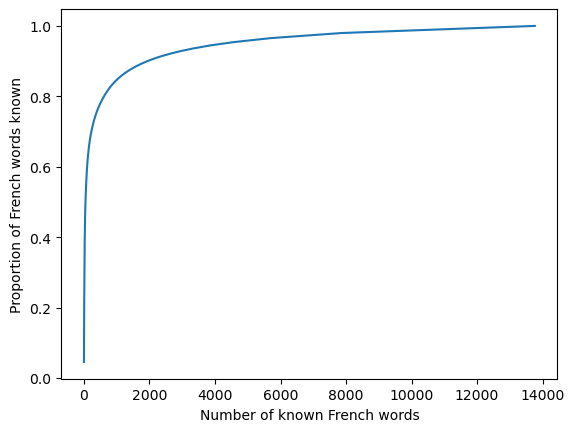

In [46]:
plt.plot(list(prop_ser))
plt.xlabel('Number of known French words')
plt.ylabel('Proportion of French words known')
plt.show()

In [47]:
Fdict_size = 2000
print(f'{round(prop_ser[Fdict_size]*100,2)}% of the dataset consists of {Fdict_size} unique words.')

97.98% of the dataset consists of 2000 unique words.


In [48]:
# Final 20 known words
counter_df.iloc[1980:2001]

,word,frequency
4669,vies,11
3043,tapis,11
9245,responsabilité,11
4597,morceaux,11
1895,travaillais,11
1167,selon,11
1889,malchanceux,11
4990,contient,11
5936,appel,11
3021,réellement,11


## Embedding and tensorised dataset

Next, we convert the above English-French sentence pair dataset into the form two Tensors: the input `X` and the target `Y`. We shall apply a word level embedding, meaning that we split the sentence into words/punctuation and punctuation, then apply a pre-trained word embedding algorithm to covert the words into vectors of size `emb_size`. The sentences have different lengths, so in order for the datapoints of the tensorial dataset to have a consistent shape, we append the necessary number of padding tokens `<pad>`. In addition, we prepend a `<bos>` token to the French sentences. 
* Unknown token `<unk>` is represented by the zero vector.
* Beginning of sentence token `<bos>`  is represented by `2*torch.ones(emb_size)`.
* Padding token `<pad>` is represented by `- 2*torch.ones(emb_size)`.


In [49]:
N_in = 7 # Length of input sentences
N_out = 8 # Length of output sentences
emb_size = 300 # Size of embedded vectors
bos_vec = 2*torch.ones(emb_size) # vector for <bos> token

Loading in pre-trained fastText word embedding vectors:

In [50]:
# French embedding
vocab_fr = torchtext.vocab.Vectors('/kaggle/input/fasttext-french-2b-300d/cc.fr.300.vec')
# English embedding
vocab_en = torchtext.vocab.Vectors('/kaggle/input/d/facebook/fasttext-wikinews/wiki-news-300d-1M.vec')

100%|██████████| 1000000/1000000 [02:24<00:00, 6925.17it/s]


Main loop:

In [51]:
data_En = data_fin.En; data_Fr = data_fin.Fr 
x_raw = vocab_en.get_vecs_by_tokens(data_En.iloc[0].split(' '))
pad_seq = -2 * torch.ones(N_in - x_raw.shape[0],emb_size)
x = torch.concat([x_raw, pad_seq],dim=0).reshape(1,N_in,emb_size) # append <pad> vectors
X = x
for sent in tqdm(data_En.iloc[1:]):
    x_raw = vocab_en.get_vecs_by_tokens(sent.split(' '))
    pad_seq = -2 * torch.ones(N_in - x_raw.shape[0],emb_size)
    x = torch.concat([x_raw, pad_seq],dim=0).reshape(1,N_in,emb_size) # append <pad> vectors
    X = torch.concat([X,x],dim=0)
y_raw = vocab_fr.get_vecs_by_tokens(data_Fr.iloc[0].split(' '))
pad_seq = -2 * torch.ones(N_out - y_raw.shape[0],emb_size)
y_raw = torch.concat([y_raw, pad_seq],dim=0)
y = torch.concat([bos_vec.unsqueeze(dim=0),y_raw],dim=0).unsqueeze(dim=0) # prepend <bos> vector
Y = y
for sent in tqdm(data_Fr.iloc[1:]):
    y_raw = vocab_fr.get_vecs_by_tokens(sent.split(' '))
    pad_seq = -2 * torch.ones(N_out - y_raw.shape[0],emb_size)
    y_raw = torch.concat([y_raw, pad_seq],dim=0)
    y = torch.concat([bos_vec.unsqueeze(dim=0),y_raw],dim=0).unsqueeze(dim=0) # prepend <bos> vector
    Y = torch.concat([Y,y],dim=0)

100%|██████████| 53868/53868 [2:47:55<00:00,  5.35it/s]


Saving tensorial dataset.

In [52]:
dataset = TensorDataset(X,Y)
torch.save(dataset,'/kaggle/working/EnFr_tensors.pt')